# **Intro**

This script will compare DIVA, Cybersort, and BayesPrism results.
In this experimental set-up, all models are trained on pbmc_rep2_10xV2.
It is then tested on an augmented/simulated bulk versions of the following single cell sample IDs

1.   pbmc_rep2_10xV2
2.   pbmc_rep1_10xV2a (different sample)
3.   pbmc_rep1_sm2 (different sample and technology)

The augmentation is done by sampling the cell proportions and overall cell numbers.
In addition there are two sources of noise: cell-type specific noise and sample specific noise.
This noise is generated by sampling a 1-centered log-normal distribution that represents a fold-change.
The sample-specific fold-change vector is sampled once per bulk sample.
The cell-type specific fold-change vectors are sampled independently, one per cell-type. 


# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [145]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [146]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 12
-rw-r--r-- 1 root root  43 Sep 22 02:08 config
-rw------- 1 root root 432 Sep 22 02:08 id_rsa
-rw-r--r-- 1 root root 113 Sep 22 02:08 id_rsa.pub


In [147]:
%%bash
# do your git operations here

git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/rotated_example_ssDIVA_mnist.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	bayesprism/
	experiments/pbmc1a_ssDIVA.ipynb
	method_comparison/
	results/
	sc_preprocessing/

no changes added to commit (use "git add" and/or "git commit -a")


# **Imports**

In [213]:
# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.stats import spearmanr, pearsonr


# Images, plots, display, and visualization
import plotnine as gg
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import gzip
from pathlib import Path

pd.set_option("display.max_columns", None)



# Load Results

In [149]:
aug_data_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/"
diva_res_data_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/results/single_cell_data/diva_pbmc/"
cs_res_data_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/results/single_cell_data/cibersort_pbmc/"
bp_res_data_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/results/single_cell_data/bp_pbmc/"


def read_files(data_path, file_idx, file_name):
  pbmc_rep1_pseudobulk_file = os.path.join(data_path, f"{file_name}_pseudo_{file_idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(data_path, f"{file_name}_prop_{file_idx}.pkl")
  pbmc_rep1_gene_file = os.path.join(data_path, f"{file_name}_genes.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  gene_path = Path(pbmc_rep1_gene_file)

  prop_df = pickle.load( open( prop_path, "rb" ) )
  pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
  gene_df = pickle.load( open( gene_path, "rb" ) )

  return (pseudobulks_df, prop_df, gene_df)

def read_results(data_path, file_name, method_str, ext):
  res_file = os.path.join(data_path, f"train-pbmc_rep2_10xV2-test-{file_name}-{method_str}.{ext}")
  res_path = Path(res_file)

  if ext == "pkl":
    res_df = pickle.load( open( res_path, "rb" ) )
  elif ext == "csv":
    res_df = pd.read_csv(res_file)
  else:
    res_df = pd.read_csv(res_file, sep="\t")

  return res_df


# load the TRUE labels
X_unseen, Y_unseen, unseen_gene_df = read_files(aug_data_path, 0, "pbmc_rep2_10xV2") #0
X_newsamp, Y_newsamp, newsamp_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_10xV2a")
X_newtech, Y_newtech, newtech_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_sm2")
X_unseen_9999, Y_unseen_9999, unseen_gene_df_9999 = read_files(aug_data_path, 9999, "pbmc_rep2_10xV2")
X_newsamp_9999, Y_newsamp_9999, newsamp_gene_df_9999 = read_files(aug_data_path, 9999, "pbmc_rep1_10xV2a")
X_newtech_9999, Y_newtech_9999, newtech_gene_df_9999 = read_files(aug_data_path, 9999, "pbmc_rep1_sm2")

# make sure cell types are in the same order
Y_newsamp = Y_newsamp[Y_unseen.columns]
Y_newsamp = Y_newsamp.to_numpy()

# we also need to ensure that the cell-types that are unobserved are still there
Y_newtech['Natural killer cell'] = 0
Y_newtech['Dendritic cell'] = 0
Y_newtech['Plasmacytoid dendritic cell'] = 0
Y_newtech = Y_newtech[Y_unseen.columns]
Y_newtech = Y_newtech.to_numpy()

# make sure cell types are in the same order
Y_unseen_9999 = Y_unseen_9999[Y_unseen.columns]
Y_unseen_9999 = Y_unseen_9999.to_numpy()

Y_newsamp_9999 = Y_newsamp_9999[Y_unseen.columns]
Y_newsamp_9999 = Y_newsamp_9999.to_numpy()

# we also need to ensure that the cell-types that are unobserved are still there
Y_newtech_9999['Natural killer cell'] = 0
Y_newtech_9999['Dendritic cell'] = 0
Y_newtech_9999['Plasmacytoid dendritic cell'] = 0
Y_newtech_9999 = Y_newtech_9999[Y_unseen.columns]
Y_newtech_9999 = Y_newtech_9999.to_numpy()


# load the DIVA results
diva_unseen = read_results(diva_res_data_path, "pbmc_rep2_10xV2", "DIVA", "pkl")
diva_newsamp = read_results(diva_res_data_path, "pbmc_rep1_10xV2a", "DIVA", "pkl")
diva_newtech = read_results(diva_res_data_path, "pbmc_rep1_sm2", "DIVA", "pkl")
diva_unseen_9999 = read_results(diva_res_data_path, "pbmc_rep2_10xV2_9999", "DIVA", "pkl")
diva_newsamp_9999 = read_results(diva_res_data_path, "pbmc_rep1_10xV2a_9999", "DIVA", "pkl")
diva_newtech_9999 = read_results(diva_res_data_path, "pbmc_rep1_sm2_9999", "DIVA", "pkl")

diva_unseen = diva_unseen[Y_unseen.columns]
diva_unseen = diva_unseen.to_numpy()

diva_newsamp = diva_newsamp[Y_unseen.columns]
diva_newsamp = diva_newsamp.to_numpy()

diva_newtech = diva_newtech[Y_unseen.columns]
diva_newtech = diva_newtech.to_numpy()


diva_unseen_9999 = diva_unseen_9999[Y_unseen.columns]
diva_unseen_9999 = diva_unseen_9999.to_numpy()

diva_newsamp_9999 = diva_newsamp_9999[Y_unseen.columns]
diva_newsamp_9999 = diva_newsamp_9999.to_numpy()

diva_newtech_9999 = diva_newtech_9999[Y_unseen.columns]
diva_newtech_9999 = diva_newtech_9999.to_numpy()


# load the cibersort results
cs_str = "CIBERSORTx_Job4_Results"
cs_unseen = read_results(cs_res_data_path, "pbmc_rep2_10xV2", cs_str, "csv")
cs_str = "CIBERSORTx_Job5_Results"
cs_newsamp = read_results(cs_res_data_path, "pbmc_rep1_10xV2a", cs_str, "csv")
cs_str = "CIBERSORTx_Job6_Results"
cs_newtech = read_results(cs_res_data_path, "pbmc_rep1_sm2", cs_str, "csv")

cs_unseen = cs_unseen[Y_unseen.columns]
cs_unseen = cs_unseen.to_numpy()

cs_newsamp = cs_newsamp[Y_unseen.columns]
cs_newsamp = cs_newsamp.to_numpy()

cs_newtech = cs_newtech[Y_unseen.columns]
cs_newtech = cs_newtech.to_numpy()


# load the bayesprism results
bp_str = "bp_10_prop"
bp_unseen = read_results(bp_res_data_path, "pbmc_rep2_10xV2", bp_str, "tsv")
bp_newsamp = read_results(bp_res_data_path, "pbmc_rep1_10xV2a", bp_str, "tsv")
bp_newtech = read_results(bp_res_data_path, "pbmc_rep1_sm2", bp_str, "tsv")

bp_unseen = bp_unseen[Y_unseen.columns]
bp_unseen = bp_unseen.to_numpy()

bp_newsamp = bp_newsamp[Y_unseen.columns]
bp_newsamp = bp_newsamp.to_numpy()

bp_newtech = bp_newtech[Y_unseen.columns]
bp_newtech = bp_newtech.to_numpy()


Y_unseen = Y_unseen.to_numpy()


# Compare Methods

In [150]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df



In [151]:
diva_unseen_err = get_errors(Y_unseen, diva_unseen)
diva_unseen_err["experiment"] = ["unseen"]*Y_unseen.shape[0]*3
diva_unseen_err["method"] = ["diva"]*Y_unseen.shape[0]*3

diva_newsamp_err = get_errors(Y_newsamp, diva_newsamp)
diva_newsamp_err["experiment"] = ["newsamp"]*Y_unseen.shape[0]*3
diva_newsamp_err["method"] = ["diva"]*Y_unseen.shape[0]*3

diva_newtech_err = get_errors(Y_newtech, diva_newtech)
diva_newtech_err["experiment"] = ["newtech"]*Y_unseen.shape[0]*3
diva_newtech_err["method"] = ["diva"]*Y_unseen.shape[0]*3

diva_unseen_9999_err = get_errors(Y_unseen_9999, diva_unseen_9999)
diva_unseen_9999_err["experiment"] = ["unseen"]*Y_unseen_9999.shape[0]*3
diva_unseen_9999_err["method"] = ["diva_9999"]*Y_unseen_9999.shape[0]*3

diva_newsamp_9999_err = get_errors(Y_newsamp_9999, diva_newsamp_9999)
diva_newsamp_9999_err["experiment"] = ["newsamp"]*Y_unseen_9999.shape[0]*3
diva_newsamp_9999_err["method"] = ["diva_9999"]*Y_unseen_9999.shape[0]*3

diva_newtech_9999_err = get_errors(Y_newtech_9999, diva_newtech_9999)
diva_newtech_9999_err["experiment"] = ["newtech"]*Y_unseen_9999.shape[0]*3
diva_newtech_9999_err["method"] = ["diva_9999"]*Y_unseen_9999.shape[0]*3


cs_unseen_err = get_errors(Y_unseen, cs_unseen)
cs_unseen_err["experiment"] = ["unseen"]*Y_unseen.shape[0]*3
cs_unseen_err["method"] = ["cs"]*Y_unseen.shape[0]*3

cs_newsamp_err = get_errors(Y_newsamp, cs_newsamp)
cs_newsamp_err["experiment"] = ["newsamp"]*Y_unseen.shape[0]*3
cs_newsamp_err["method"] = ["cs"]*Y_unseen.shape[0]*3

cs_newtech_err = get_errors(Y_newtech, cs_newtech)
cs_newtech_err["experiment"] = ["newtech"]*Y_unseen.shape[0]*3
cs_newtech_err["method"] = ["cs"]*Y_unseen.shape[0]*3



bp_unseen_err = get_errors(Y_unseen, bp_unseen)
bp_unseen_err["experiment"] = ["unseen"]*bp_unseen.shape[0]*3
bp_unseen_err["method"] = ["bp"]*bp_unseen.shape[0]*3


bp_newsamp_err = get_errors(Y_newsamp, bp_newsamp)
bp_newsamp_err["experiment"] = ["newsamp"]*bp_newsamp.shape[0]*3
bp_newsamp_err["method"] = ["bp"]*bp_newsamp.shape[0]*3


bp_newtech_err = get_errors(Y_newtech, bp_newtech)
bp_newtech_err["experiment"] = ["newtech"]*bp_newtech.shape[0]*3
bp_newtech_err["method"] = ["bp"]*bp_newtech.shape[0]*3


MSqE mean: 0.0028196595855398353, median: 0.0023382966216658023, max: 0.015438423341291814
Spearman mean: 0.666142578217783, median: 0.7, max: 1.0
Pearson mean: 0.8302544653251216, median: 0.887306252299322, max: 0.9995973491760538
MSqE mean: 0.00381059870346623, median: 0.003190232245149074, max: 0.01961010711228048
Spearman mean: 0.5947655873350487, median: 0.6333333333333333, max: 0.9833333333333333
Pearson mean: 0.7513859077666587, median: 0.823788405053697, max: 0.9969699016704004
MSqE mean: 0.02211590616375149, median: 0.019034990755192438, max: 0.12242237037935462
Spearman mean: 0.2687858499418218, median: 0.27240208984279957, max: 0.7967246167544523
Pearson mean: 0.37454840628503155, median: 0.3897951348608093, max: 0.9944628239045564
MSqE mean: 0.0035254766563315373, median: 0.0032322631260951824, max: 0.011120564037706034
Spearman mean: 0.83375, median: 0.8499999999999999, max: 1.0
Pearson mean: 0.8482953072828043, median: 0.856635875632983, max: 0.9933474746643658
MSqE mean:

[ 1. 10. 26.  2. 14.  5.  2. 11. 28.]
[ 1.  7.  5.  2. 68.  4.  1.  5.  8.]
[0.01031325 0.00552071 0.05723186 0.00545105 0.14238772 0.00403398
 0.02067157 0.00184808 0.02209385 0.00746351]
[0.0975 0.06 0.3805 0.058 0.677 0.045 0.1495 0.0185 0.197 0.0685]
pearson: 0.9865382078757663


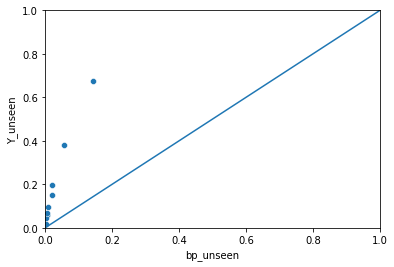

In [221]:
idx = 4
print(np.round(bp_unseen[idx,]*100))
print(np.round(Y_unseen[idx,:].astype(np.double)*100))

np.mean((bp_unseen[idx,] - Y_unseen[idx,:])**2)

print(bp_unseen[0:10,idx])
print(Y_unseen[0:10,idx])
print(f"pearson: {pearsonr(bp_unseen[0:10,idx], Y_unseen[0:10,idx])[0]}")

plot_matr = np.vstack((np.round(bp_unseen[0:10,idx],3), Y_unseen[0:10,idx]))
plot_df = pd.DataFrame(plot_matr.transpose())
plot_df.columns = ["bp_unseen", "Y_unseen"]

gg = sns.scatterplot(
    x="bp_unseen", y="Y_unseen",
    data=plot_df
)
gg.set(ylim=(0, 1))
gg.set(xlim=(0, 1))
gg.plot([0, 1], [0, 1], transform=gg.transAxes)


[ 3.  5.  4.  2. 64.  2.  3.  7.  9.]
[ 1.  7.  5.  2. 68.  4.  1.  5.  8.]
[0.08396637 0.09102385 0.27443776 0.09377094 0.63951933 0.07937989
 0.26374725 0.08556664 0.27682865 0.05904273]
[0.0975 0.06 0.3805 0.058 0.677 0.045 0.1495 0.0185 0.197 0.0685]
pearson: 0.7987636868781246


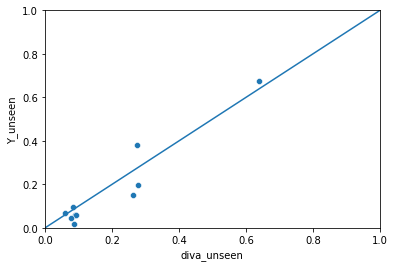

In [222]:
print(np.round(diva_unseen[idx,]*100))
print(np.round(Y_unseen[idx,:].astype(np.double)*100))


np.mean((diva_unseen[idx,] - Y_unseen[idx,:])**2)

print(diva_unseen[0:10,idx])
print(Y_unseen[0:10,idx])
print(f"pearson: {pearsonr(diva_unseen[:,idx], Y_unseen[:,idx])[0]}")

plot_matr = np.vstack((np.round(diva_unseen[0:10,idx],3), Y_unseen[0:10,idx]))
plot_df = pd.DataFrame(plot_matr.transpose())
plot_df.columns = ["diva_unseen", "Y_unseen"]

gg = sns.scatterplot(
    x="diva_unseen", y="Y_unseen",
    data=plot_df
)
gg.set(ylim=(0, 1))
gg.set(xlim=(0, 1))
gg.plot([0, 1], [0, 1], transform=gg.transAxes)


In [193]:
diva_unseen[0:10,idx]

array([0.08396637, 0.09102385, 0.27443776, 0.09377094, 0.63951933,
       0.07937989, 0.26374725, 0.08556664, 0.27682865, 0.05904273],
      dtype=float32)

# Plot Comparisons

       error error_type experiment method
0   0.001636        MSQ     unseen   diva
1   0.000936        MSQ     unseen   diva
2   0.002093        MSQ     unseen   diva
3   0.001741        MSQ     unseen   diva
4   0.000394        MSQ     unseen   diva
..       ...        ...        ...    ...
25  0.931582       PEAR    newtech     bp
26  0.743517       PEAR    newtech     bp
27  0.844209       PEAR    newtech     bp
28  0.958235       PEAR    newtech     bp
29  0.958218       PEAR    newtech     bp

[27090 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


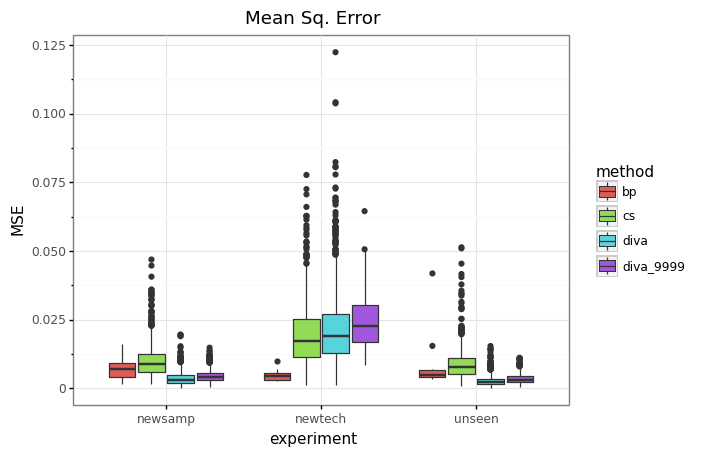

<ggplot: (8753463444401)>

In [154]:
plot_df = pd.concat([diva_unseen_err, diva_newsamp_err, diva_newtech_err, 
                     diva_unseen_9999_err, diva_newsamp_9999_err, diva_newtech_9999_err, 
                     cs_unseen_err, cs_newsamp_err, cs_newtech_err,
                     bp_unseen_err, bp_newsamp_err, bp_newtech_err,])
print(plot_df)
(
    gg.ggplot(plot_df[plot_df["error_type"] == "MSQ"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Mean Sq. Error", y="MSE") +
    gg.theme_bw()

)



/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


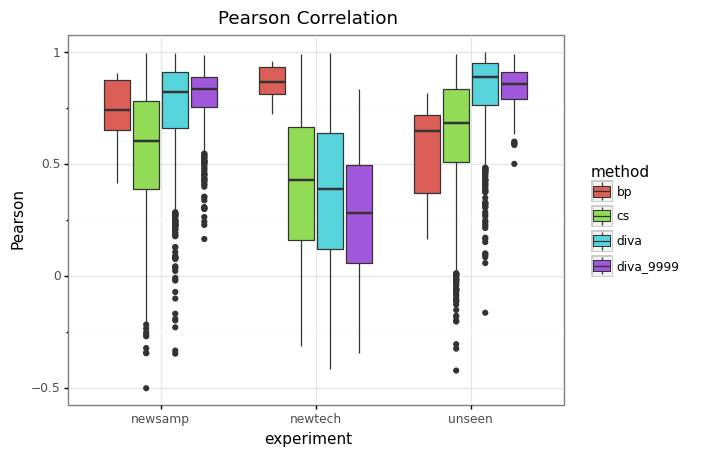

<ggplot: (8753479019045)>

In [155]:
(
    gg.ggplot(plot_df[plot_df["error_type"] == "PEAR"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Pearson Correlation", y="Pearson") +
    gg.theme_bw()

)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


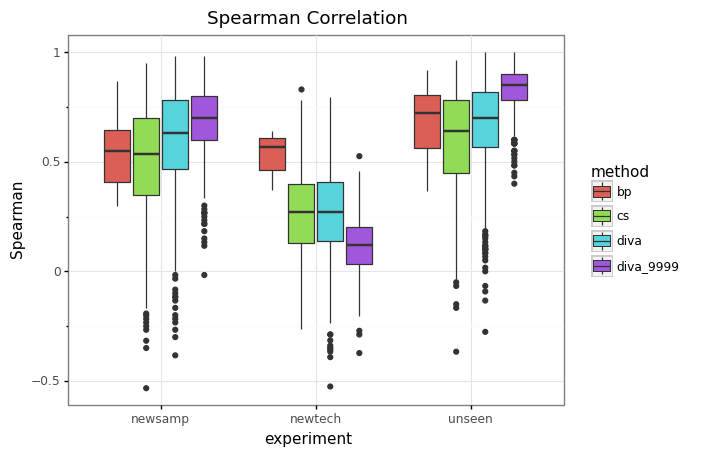

<ggplot: (8753478958265)>

In [157]:
(
    gg.ggplot(plot_df[plot_df["error_type"] == "SPR"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Spearman Correlation", y="Spearman") +
    gg.theme_bw()
)